# Law School Dataset - Fairness Analysis

This notebook evaluates fairness vs information retention trade-offs on the Law School Admissions dataset.

**Dataset**: LSAC Law School (~21,000 samples)

**Sensitive Attribute**: Race (White vs Minority)

**Task**: Predict bar exam passage

In [1]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

from datasets import load_law_school, get_dataset_summary
from fairness_metrics import compute_all_fairness_metrics, compute_performance_metrics
from preprocessing import Reweighing, DisparateImpactRemover, LabelFlipping, SamplingStrategy
from inprocessing import FairnessRegularizedClassifier, AdversarialDebiasing, ConstrainedClassifier
from postprocessing import EqualizedOddsPostProcessor, ThresholdOptimizer, CalibratedPostProcessor, RejectOptionClassifier
from visualization import plot_accuracy_fairness_tradeoff, plot_pareto_frontier, create_summary_dashboard

print("Modules loaded!")

Modules loaded!


## 1. Data Loading

In [2]:
data = load_law_school(sensitive_attr='race', random_state=42)
display(get_dataset_summary(data))

X_train, X_test = data['X_train'], data['X_test']
y_train, y_test = data['y_train'], data['y_test']
sens_train, sens_test = data['sensitive_train'], data['sensitive_test']

print(f"Training: {len(X_train)}, Test: {len(X_test)}, Features: {X_train.shape[1]}")

,Dataset,Task,N Train,N Test,N Features,Positive Rate (Train),Sensitive Attr,Group 0 Rate,Group 1 Rate,Group 0 Pos Rate,Group 1 Pos Rate,Disparate Impact
0,Law School,Bar exam passage prediction,14558,6240,9,88.98%,race,16.09%,83.91%,72.26%,92.18%,0.784


Training: 14558, Test: 6240, Features: 9


## 2. All Methods

In [3]:
results = []

def evaluate_model(y_true, y_pred, y_prob, sensitive, method_name, category):
    perf = compute_performance_metrics(y_true, y_pred, y_prob)
    fair = compute_all_fairness_metrics(y_true, y_pred, y_prob, sensitive)
    return {
        'Method': method_name, 'Category': category,
        'Accuracy': perf['accuracy'], 'AUC': perf.get('auc', np.nan),
        'Precision': perf['precision'], 'Recall': perf['recall'], 'F1': perf['f1'],
        'DPD': fair['demographic_parity_difference'],
        'EOD': fair['equalized_odds_difference']['average']
    }

In [4]:
# Baseline
baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
baseline_clf.fit(X_train, y_train)
y_pred_baseline = baseline_clf.predict(X_test)
y_prob_baseline = baseline_clf.predict_proba(X_test)[:, 1]
results.append(evaluate_model(y_test, y_pred_baseline, y_prob_baseline, sens_test, 'Baseline', 'Baseline'))
print(f"Baseline: Acc={results[-1]['Accuracy']:.4f}, DPD={results[-1]['DPD']:.4f}")

Baseline: Acc=0.8990, DPD=0.1591


In [5]:
# Pre-processing
reweigher = Reweighing()
reweigher.fit(X_train, y_train, sens_train)
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train, sample_weight=reweigher.get_weights())
results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, 'Reweighing', 'Pre-processing'))

for rl in [0.5, 1.0]:
    dir_proc = DisparateImpactRemover(sensitive_attr_idx=0, repair_level=rl)
    dir_proc.fit(X_train, sensitive=sens_train)
    X_tr = dir_proc.transform(X_train, sens_train)
    X_te = dir_proc.transform(X_test, sens_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_tr, y_train)
    results.append(evaluate_model(y_test, clf.predict(X_te), clf.predict_proba(X_te)[:, 1], sens_test, f'DIR (r={rl})', 'Pre-processing'))

for strategy in ['targeted', 'equalize']:
    flipper = LabelFlipping(flip_rate=0.1, strategy=strategy)
    flipper.fit(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train, flipper.transform(y_train))
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'LabelFlip ({strategy})', 'Pre-processing'))

for strategy in ['oversample', 'undersample', 'hybrid']:
    sampler = SamplingStrategy(strategy=strategy)
    X_res, y_res, s_res = sampler.fit_resample(X_train, y_train, sens_train)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_res, y_res)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Sampling ({strategy})', 'Pre-processing'))

print(f"Pre-processing methods complete: {len([r for r in results if r['Category'] == 'Pre-processing'])} methods")

Pre-processing methods complete: 8 methods


In [6]:
# In-processing
for lf in [0.1, 0.5, 1.0, 2.0]:
    clf = FairnessRegularizedClassifier(lambda_fairness=lf, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'FairReg (λ={lf})', 'In-processing'))

for aw in [0.5, 1.0]:
    try:
        clf = AdversarialDebiasing(adversary_weight=aw, n_epochs=30, use_pytorch=True)
        clf.fit(X_train, y_train, sens_train)
        results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Adversarial (w={aw})', 'In-processing'))
    except:
        pass

for th in [0.05, 0.1]:
    clf = ConstrainedClassifier(constraint_threshold=th, max_iter=500)
    clf.fit(X_train, y_train, sens_train)
    results.append(evaluate_model(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1], sens_test, f'Constrained (ε={th})', 'In-processing'))

print(f"In-processing methods complete: {len([r for r in results if r['Category'] == 'In-processing'])} methods")

In-processing methods complete: 8 methods


In [7]:
# Post-processing
y_prob_train = baseline_clf.predict_proba(X_train)[:, 1]

eo = EqualizedOddsPostProcessor()
eo.fit(y_train, y_prob_train, sens_train)
results.append(evaluate_model(y_test, eo.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, 'Equalized Odds', 'Post-processing'))

for fw in [0.3, 0.5, 0.7]:
    to = ThresholdOptimizer(fairness_weight=fw)
    to.fit(y_train, y_prob_train, sens_train)
    results.append(evaluate_model(y_test, to.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, f'ThreshOpt (w={fw})', 'Post-processing'))

cal = CalibratedPostProcessor(n_bins=10)
cal.fit(y_train, y_prob_train, sens_train)
y_prob_cal = cal.transform(y_prob_baseline, sens_test)
results.append(evaluate_model(y_test, (y_prob_cal >= 0.5).astype(int), y_prob_cal, sens_test, 'Calibrated', 'Post-processing'))

priv = 1 if y_train[sens_train == 1].mean() > y_train[sens_train == 0].mean() else 0
ro = RejectOptionClassifier(privileged_group=priv)
ro.fit(y_train, y_prob_train, sens_train)
results.append(evaluate_model(y_test, ro.transform(y_prob_baseline, sens_test), y_prob_baseline, sens_test, 'Reject Option', 'Post-processing'))

print(f"Post-processing methods complete: {len([r for r in results if r['Category'] == 'Post-processing'])} methods")

Post-processing methods complete: 6 methods


## 3. Results

In [8]:
results_df = pd.DataFrame(results)
display(results_df.sort_values('Accuracy', ascending=False))

,Method,Category,Accuracy,AUC,Precision,Recall,F1,DPD,EOD
15,Constrained (ε=0.05),In-processing,0.900962,NaN,0.911304,0.984510,0.946494,0.173744,0.222392
21,Calibrated,Post-processing,0.899038,NaN,0.910714,0.982889,0.945426,0.159111,0.202536
0,Baseline,Baseline,0.899038,NaN,0.910714,0.982889,0.945426,0.159111,0.202536
18,ThreshOpt (w=0.3),Post-processing,0.899038,NaN,0.910714,0.982889,0.945426,0.159111,0.202536
20,ThreshOpt (w=0.7),Post-processing,0.899038,NaN,0.910714,0.982889,0.945426,0.159111,0.202536
19,ThreshOpt (w=0.5),Post-processing,0.899038,NaN,0.910714,0.982889,0.945426,0.159111,0.202536
16,Constrained (ε=0.1),In-processing,0.899038,NaN,0.908126,0.986311,0.945605,0.156498,0.206979
13,Adversarial (w=0.5),In-processing,0.897917,NaN,0.911573,0.980367,0.944719,0.108509,0.116761
3,DIR (r=1.0),Pre-processing,0.897756,NaN,0.908140,0.984690,0.944867,0.111662,0.122305
2,DIR (r=0.5),Pre-processing,0.897115,NaN,0.909167,0.982529,0.944425,0.104191,0.109133


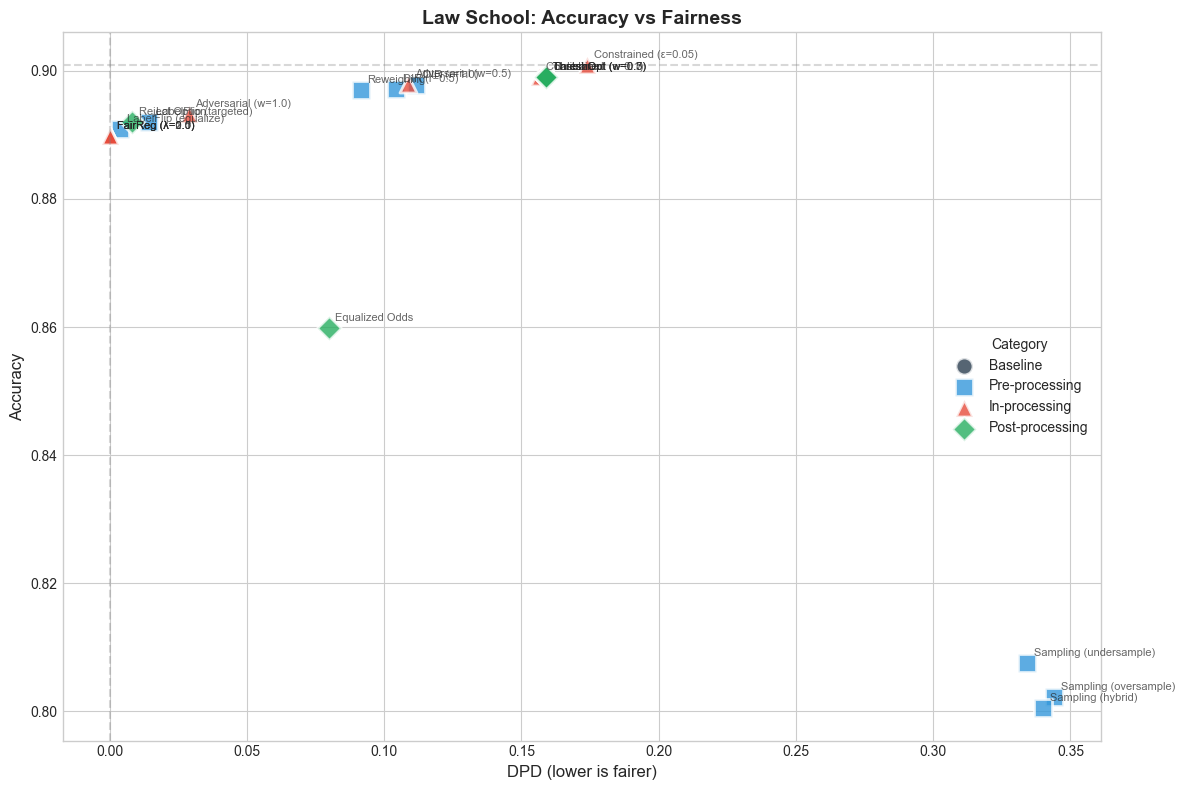

In [9]:
fig = plot_accuracy_fairness_tradeoff(results_df, title='Law School: Accuracy vs Fairness')
plt.show()

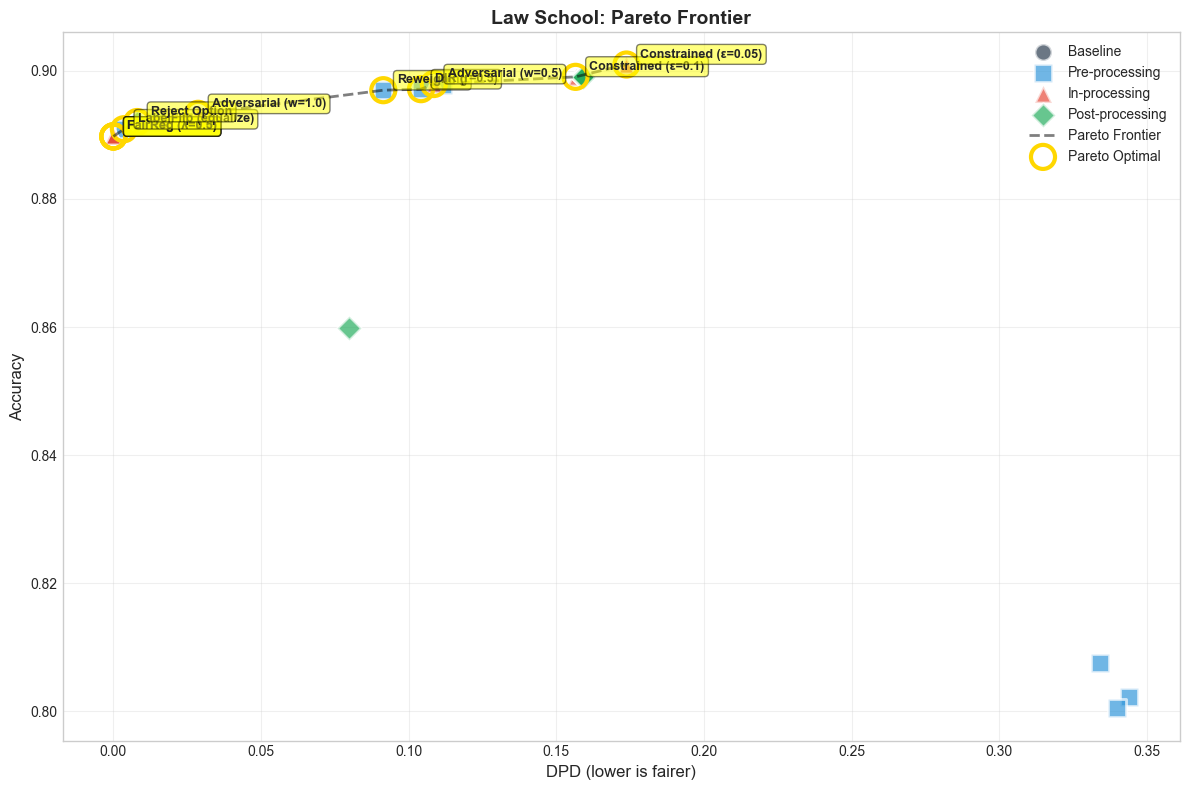

In [10]:
fig = plot_pareto_frontier(results_df, title='Law School: Pareto Frontier')
plt.show()

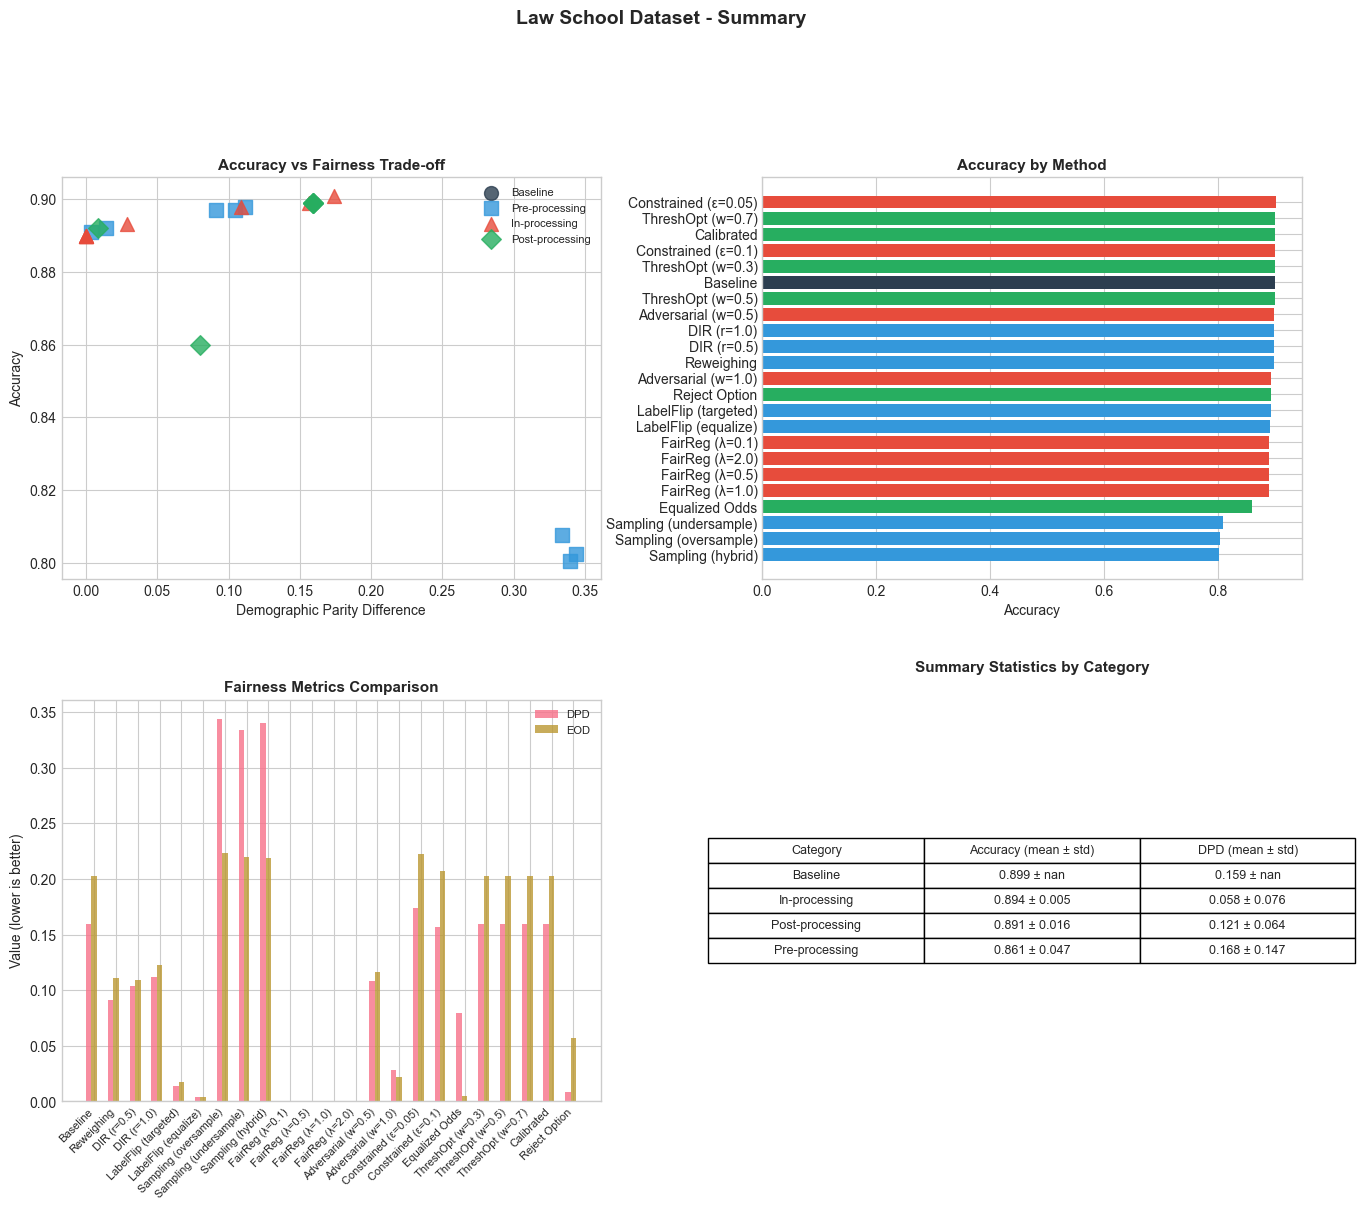

In [11]:
fig = create_summary_dashboard(results_df, title='Law School Dataset - Summary')
plt.show()

In [12]:
results_df.to_csv('../results/law_school_results.csv', index=False)
print("Results saved!")

Results saved!
